# Implementing SK-ROCK algorithm - Application to CS-MRI

In this notebook I implement the recently-developed algorithm by Luis Vargas, Marcelo Pereyra and Konstantinos Zygakalis found in [this paper](https://arxiv.org/pdf/1908.08845.pdf).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift
from skimage import data, img_as_float
import helper as t

import time
from tqdm import tqdm_notebook

import pysap;
from pysap.data import get_sample_data;
from mri.numerics.fourier import NFFT
from mri.numerics.reconstruct import sparse_rec_fista
from mri.numerics.reconstruct import sparse_rec_condatvu
from mri.numerics.utils import generate_operators
from mri.numerics.utils import convert_mask_to_locations
from mri.reconstruct.linear import WaveletN, WaveletUD2
from modopt.math.metrics import ssim
from mri.numerics.fourier import FFT2
from mri.numerics.reconstruct import sparse_rec_fista
from mri.numerics.utils import generate_operators
from mri.numerics.utils import convert_mask_to_locations
from pysap.data import get_sample_data
from sklearn.metrics import mean_squared_error


# Third party import
import numpy as np
import scipy.fftpack as pfft


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
pysparse       : >=0.0.1   - required | 0.1.0     installed
matplotlib     : >=3.0.0   - required | 3.0.3     installed
pywt           : >=1.0.0   - required | 1.0.3     installed
scikit-learn   : >=0.19.1  - required | ?         installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.0     installed
numpy          : >=1.16.4  - required | 1.17.2    installed
nibabel        : >=2.3.2   - requi

The image we will be working with for the purposes of this project is the [Shepp Logan phantom](https://en.wikipedia.org/wiki/Shepp%E2%80%93Logan_phantom), and so we load it in the next cell. The version I am using is a small file - 128 x 128 pixels.

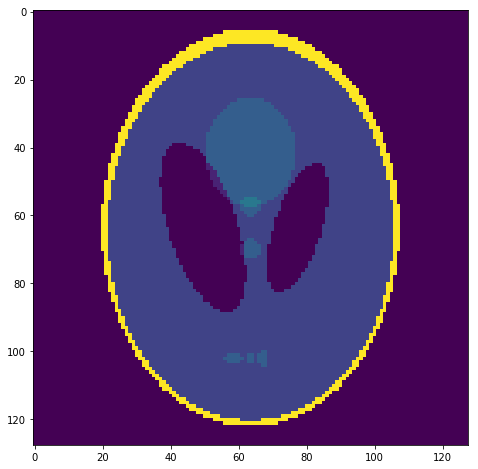

In [2]:
fig =plt.figure(figsize=(10,8))
original_image = np.load('phantom.npy')
plt.imshow(original_image)
plt.show()

We will use a radial mask for the purposes of this experiment.

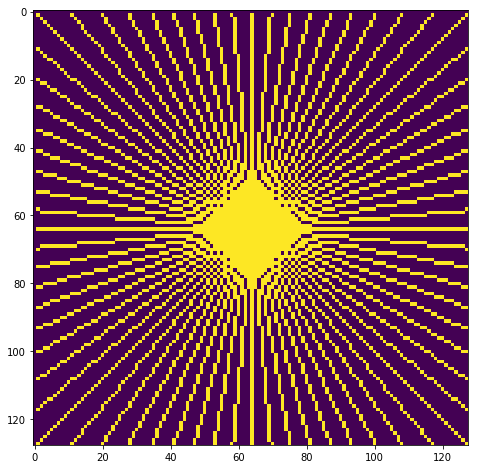

In [3]:
mask_temp = t.LineMask(number_of_angles=36, dim=128)
mask = fftshift(mask_temp)
fig =plt.figure(figsize=(10,8))
plt.imshow(mask)
plt.show()

Now we use the mask to generate the k-space data.

In [4]:
kspace_loc = convert_mask_to_locations(np.fft.fftshift(mask.data))
fourier_op = FFT2(samples=kspace_loc, shape=original_image.shape)
kspace_data = fourier_op.op(original_image)

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


## SK-ROCK Algorithm

The following function generates a given number of samples, given original data, according to the SK-ROCK algorithm

In [5]:
def sk_rock(observations, num_samples, sigma=1e-3/np.sqrt(2), num_stages=10, eta=0.05 ):
    """
    Generates samples from high-dimensional distributions, according to SK-ROCK 
    algorithm proposed by Luis Vargas et al (2019).
    
    INPUTS:
     - original_guess: initialisation of algorithm
     - image: number of samples to generate
     - sigma, eta: hyperparameters of prior
     - num_stages: number of internal Runge-Kutta stages
    
    OUTPUTS:
     - logPiTraces: array containing the values of logPi
     - data[-1]: the reconstructed image
     
    """
    alpha = 5e-4/sigma**2 # hyperparameter of prior
    lam = 0.2 *sigma**2  #approximation parameter of the MY envelop
    lipschitz_log_likelihood = 1/sigma**2 #Lipschitz constant of the log-likelihood 
    original_guess = fourier_op.adj_op(observations)
    
    
    ## Gradients - proximal gradients and other functions
    def gradF(x):
        return (fourier_op.adj_op(fourier_op.op(x) - observations))/sigma**2
        
    
    def proxG(x, param=alpha*lam):
        return t.chambolle_prox_TV(x, param, 25)
    
    def gradG(x):
        return (x - proxG(x))/lam
    
    def gradU(x):
        return gradF(x) + gradG(x)
    
    def logPi(x):
        return -(np.linalg.norm(observations - fourier_op.op(x))**2)/(2*sigma**2) - alpha*t.TVnorm(x)
    
       
    l = (num_stages - 0.5)**2 * (2 - (4/3)*eta) - 1.5
    step_size = 0.8*l/(lipschitz_log_likelihood + 1/lam)
        
    omega_0 = 1 + eta/num_stages**2
    omega_1 = t.chebyshev(num_stages, omega_0)/t.chebyshev_prime(num_stages, omega_0)
    mu_1 = omega_1/omega_0
    nu_1 = num_stages*omega_1/2
    kappa_1 = num_stages*omega_1/omega_0
    dimension = original_guess.shape[0]
    
    
    K = np.ndarray((num_stages, dimension, dimension), dtype=np.complex64)
    data = np.ndarray((num_samples, dimension, dimension), dtype=np.complex64)
    logPiTraces = np.zeros(num_samples)
    data[0] = original_guess
    logPiTraces[0] = logPi(data[0])
    
    for i in tqdm_notebook(range(num_samples-1)):
        Z = np.random.randn(dimension, dimension)
        K[0] = data[i]
        K[1] = K[0] - mu_1*step_size*gradU(K[0] + 
                    nu_1*np.sqrt(2*step_size)*Z) + kappa_1*np.sqrt(2*step_size)*Z
        
        for j in range(2,num_stages):
            mu = 2*omega_1*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            nu = 2*omega_0*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            kappa = 1 - nu
            
            K[j] = -mu *step_size*gradU(K[j-1])+ nu*K[j-1]+ kappa*K[j-2]
        data[i+1] = K[num_stages-1]
        logPiTraces[i+1] = logPi(data[i+1])
    return logPiTraces, abs(data[-1])

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part


/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


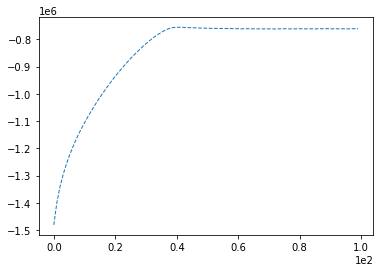

In [6]:
num_samples = 1000 #Generation of samples
logPiTraces, image_rec_skrock = sk_rock(kspace_data, num_samples)
plt.plot(range(num_samples),logPiTraces, linewidth=1, ls='--')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-24, -7))
plt.show()

From the cell above we see that the algorithm converges, and confirms the result in the paper. Now I want to compare this algorithm, which is MCMC based, to the more optimisation-based algorithms. In this case I will compare with the FISTA algorithm.

## FISTA Reconstruction

To begin with, I perform some sort of a grid search to identify the best regularization parameter for FISTA in this case. I use the mean squared error as the evaluation metric in this case.

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  7% (7 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:01


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  1e-05
 - lipschitz constant:  1.1000000000004024
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6a39e8> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 - final iteration number:  100
 - final log10 cost value:  -1.969577934517299
 - converged:  False
Done.
Execution time:  74.45386099999996  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  2.782559402207126e-05
 - lipschitz constant:  1.1000000000004073
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6b28d0> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 - final iteration number:  100
 - final log10 cost value:  -1.5460389017230358
 - converged:  False
Done.
Execution time:  77.38154299999951  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  7.742636826811278e-05
 - lipschitz constant:  1.1000000000003953
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6449e8> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 - final iteration number:  100
 - final log10 cost value:  -1.1293137591196236
 - converged:  False
Done.
Execution time:  71.20298000000003  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.00021544346900318823
 - lipschitz constant:  1.1000000000004055
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6a62b0> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 - final iteration number:  100
 - final log10 cost value:  -0.7141818201731427
 - converged:  False
Done.
Execution time:  75.72752500000024  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.0005994842503189409
 - lipschitz constant:  1.1000000000003962
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6a6588> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 - final iteration number:  100
 - final log10 cost value:  -0.2895974264681172
 - converged:  False
Done.
Execution time:  74.27634899999975  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.0016681005372000592
 - lipschitz constant:  1.1000000000003973
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d644eb8> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 - final iteration number:  100
 - final log10 cost value:  0.1471439564924399
 - converged:  False
Done.
Execution time:  73.9843719999999  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.004641588833612777
 - lipschitz constant:  1.100000000000398
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6514a8> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 - final iteration number:  100
 - final log10 cost value:  0.585527473558394
 - converged:  True
Done.
Execution time:  74.81412300000011  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.012915496650148827
 - lipschitz constant:  1.1000000000004058
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d6a6048> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  6% (6 of 100) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 - final iteration number:  100
 - final log10 cost value:  1.0151894062560918
 - converged:  True
Done.
Execution time:  75.72435500000029  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.03593813663804626
 - lipschitz constant:  1.1000000000003889
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d644ef0> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
  3% (3 of 100) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00

 - final iteration number:  100
 - final log10 cost value:  1.423154648151813
 - converged:  True
Done.
Execution time:  71.65050499999961  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.1
 - lipschitz constant:  1.1000000000004102
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d651860> - 3
 - max iterations:  100
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


 - final iteration number:  100
 - final log10 cost value:  1.7941155511759859
 - converged:  True
Done.
Execution time:  72.5797679999996  seconds
----------------------------------------



AttributeError: 'AxesSubplot' object has no attribute 'yscale'

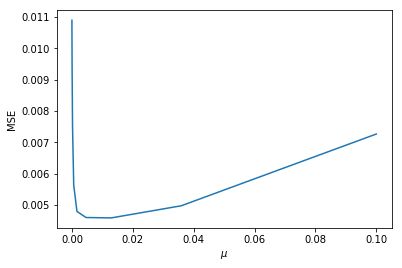

In [23]:
mu = np.logspace(-5, -1, 10)
mses = []
for each in tqdm_notebook(mu):
    # Generate operators
    gradient_op, linear_op, prox_op, cost_op = generate_operators(
        data=kspace_data,
        wavelet_name="sym8",
        samples=kspace_loc,
        nb_scales=3,
        mu=each,
        uniform_data_shape=None,
        gradient_space="synthesis",
        padding_mode="periodization")

    # Start the FISTA reconstruction
    max_iter = 100
    x_final, costs, metrics = sparse_rec_fista(
        gradient_op,
        linear_op,
        prox_op,
        cost_op,
        lambda_init=1,
        max_nb_of_iter=max_iter,
        atol=1e-4,
        verbose=1)
    image_rec_fista = pysap.Image(data=np.abs(x_final))
    #plt.imshow(image_rec_fista)
    
    mses.append(mean_squared_error(image_rec_fista, original_image))


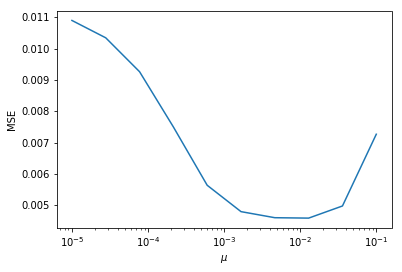

In [24]:
fig = plt.figure()
ax = plt.axes()
plt.plot(mu, mses)
ax.set_xlabel('$\mu$')
ax.set_ylabel('MSE')
plt.xscale('log')
plt.show()

From the cell above, we see that the value of $mu$ which yields the smallest MSE is about 0.005, and so we use that in the next cell to generate a reconstructed image.

In [25]:
# Generate operators
gradient_op, linear_op, prox_op, cost_op = generate_operators(
    data=kspace_data,
    wavelet_name="db4",
    samples=kspace_loc,
    nb_scales=5,
    mu=5e-3,
    uniform_data_shape=None,
    gradient_space="synthesis",
    padding_mode="periodization")

# Start the FISTA reconstruction
max_iter = 200
x_final, costs, metrics = sparse_rec_fista(
    gradient_op,
    linear_op,
    prox_op,
    cost_op,
    lambda_init=1,
    max_nb_of_iter=max_iter,
    atol=1e-4,
    verbose=1)
image_rec_fista = pysap.Image(data=np.abs(x_final))

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/mri/reconstruct/utils.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1
/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
  3% (6 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  0.005
 - lipschitz constant:  1.0999999999999999
 - data:  (128, 128)
 - wavelet:  <mri.reconstruct.linear.WaveletN object at 0x7fa44d5cda90> - 5
 - max iterations:  200
 - image variable shape:  (128, 128)
 - alpha variable shape:  (16384,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


 - final iteration number:  200
 - final log10 cost value:  0.5860652219679905
 - converged:  True
Done.
Execution time:  147.1814890000005  seconds
----------------------------------------


## Comparison of reconstructed images

We now compare the reconstructed images from SK-ROCK and FISTA. In particular, we will be using their Mean-Squared-Error

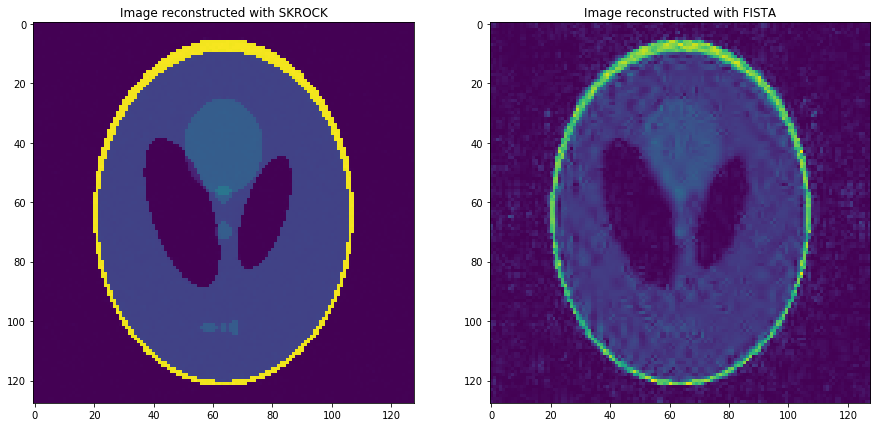

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(image_rec_skrock)
ax[0].set_title('Image reconstructed with SKROCK')
ax[1].imshow(image_rec_fista)
ax[1].set_title('Image reconstructed with FISTA')
plt.show()

In [27]:
error_skrock = mean_squared_error(image_rec_skrock, original_image)
error_fista = mean_squared_error(image_rec_fista, original_image)
improvement = (error_fista - error_skrock)/error_fista * 100
print(improvement)

99.69287676111568


In [22]:
error_fista

0.004625571084465253

We see that there is a very clear difference in the reconstructed images. The image generated by SK-ROCK is much clearer and resembles the original way more closely than that generated by FISTA. 

There seems to be almost a 100% improvement in mean-square error in this case. This looks too good to be true, and therefore warrants more investigation.

## Using wavelet operators in SK-ROCK

At this stage we want to replace the linear operator. Instead of using the Total Variation norm, we want to use a wavelet transform of the image to see how well the algorithm will perform

In [11]:
wavelet_operator = WaveletN(wavelet_name="sym8", nb_scale=4)
wavelet_image = wavelet_operator.op(original_image)

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


We will use an L1 regularizer in this case, and the proximal operator will be the soft thresholding operator, which we define in the cell below.

In [12]:
def own_soft_thresh(x, beta):
    sgn_x = x / np.abs(x)
    return np.maximum(np.abs(x) - beta, 0.0) * sgn_x

The function below is a modification of the original sk-rock function, which takes into account the wavelet operators, and replaces the chambolle proximal operator with the soft thresholding operator.

In [13]:
def sk_rock_wavelet(observations, num_samples, sigma=1e-3/np.sqrt(2), num_stages=10, eta=0.05 ):
    """
    Generates samples from high-dimensional distributions, according to SK-ROCK 
    algorithm proposed by Luis Vargas et al (2019).
    
    INPUTS:
     - original_guess: initialisation of algorithm
     - image: number of samples to generate
     - sigma, eta: hyperparameters of prior
     - num_stages: number of internal Runge-Kutta stages
    
    OUTPUTS:
     - logPiTraces: array containing the values of logPi
     - data[-1]: the reconstructed image
     
    """
    alpha = 5e-4/sigma**2 # hyperparameter of prior
    lam = 0.2 *sigma**2  #approximation parameter of the MY envelop
    lipschitz_log_likelihood = 1/sigma**2 #Lipschitz constant of the log-likelihood 
    original_guess = fourier_op.adj_op(observations)
    
    
    ## Gradients - proximal gradients and other functions
    def gradF(x):
        return (fourier_op.adj_op(fourier_op.op(x) - observations))/sigma**2
        
    
    def proxG(x, param=alpha*lam):
        return own_soft_thresh(x,param)
    
    def gradG(x):
        return x + wavelet_operator.adj_op(proxG(wavelet_operator.op(x)) - wavelet_operator.op(x))/lam
    
    def gradU(x):
        return gradF(x) + gradG(x)
    
    def logPi(x):
        return -(np.linalg.norm(observations - fourier_op.op(x))**2)/(2*sigma**2) - alpha*t.np.sum(wavelet_operator.op(x))
    
       
    l = (num_stages - 0.5)**2 * (2 - (4/3)*eta) - 1.5
    step_size = 0.8*l/(lipschitz_log_likelihood + 1/lam)
        
    omega_0 = 1 + eta/num_stages**2
    omega_1 = t.chebyshev(num_stages, omega_0)/t.chebyshev_prime(num_stages, omega_0)
    mu_1 = omega_1/omega_0
    nu_1 = num_stages*omega_1/2
    kappa_1 = num_stages*omega_1/omega_0
    dimension = original_guess.shape[0]
    
    
    K = np.ndarray((num_stages, dimension, dimension), dtype=np.complex64)
    data = np.ndarray((num_samples, dimension, dimension), dtype=np.complex64)
    logPiTraces = np.zeros(num_samples)
    data[0] = original_guess
    logPiTraces[0] = logPi(data[0])
    
    for i in tqdm_notebook(range(num_samples-1)):
        Z = np.random.randn(dimension, dimension)
        K[0] = data[i]
        K[1] = K[0] - mu_1*step_size*gradU(K[0] + 
                    nu_1*np.sqrt(2*step_size)*Z) + kappa_1*np.sqrt(2*step_size)*Z
        
        for j in range(2,num_stages):
            mu = 2*omega_1*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            nu = 2*omega_0*t.chebyshev(j-1, omega_0)/t.chebyshev(j, omega_0)
            kappa = 1 - nu
            
            K[j] = -mu *step_size*gradU(K[j-1])+ nu*K[j-1]+ kappa*K[j-2]
        data[i+1] = K[num_stages-1]
        logPiTraces[i+1] = logPi(data[i+1])
    return logPiTraces, abs(data[-1])

/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part


/volatile/home/bemsi/bemsi-python/lib/python3.5/site-packages/ipykernel_launcher.py:71: ComplexWarning: Casting complex values to real discards the imaginary part


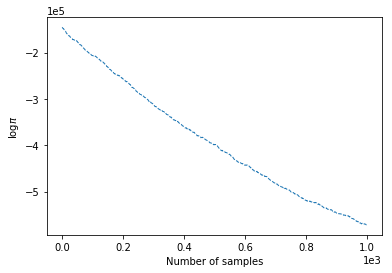

In [14]:
num_samples = 1000 #Generation of samples
logPiTraces, images = sk_rock_wavelet(kspace_data, num_samples)
plt.plot(range(num_samples),logPiTraces, linewidth=1, ls='--')
plt.ticklabel_format(axis='both', style='sci', scilimits=(-24, -7))
plt.xlabel('Number of samples')
plt.ylabel('$\log \pi$')
plt.show()

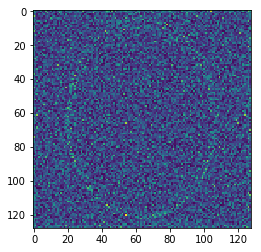

In [15]:
plt.imshow(images)
plt.show()

We see from the plot of $\log \pi$ against number of samples that there is convergence, but the image is not clear. This is likely due to the parameter used in soft thresholding operator.